# Tutorial

In [1]:
import os
import random
import numpy as np
import scanpy as sc
import torch
from torch.utils.data import DataLoader
import argparse
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
import seaborn as sns

from dataset import Dataset
from model import SpaCLR, TrainerSpaCLR
from utils import get_predicted_results, load_ST_file
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

2024-08-22 14:17:22.208126: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
os.environ['R_HOME'] = '/disk2/user/cormey/miniconda3/envs/my_env03/lib/R'
os.environ['R_LIBS_USER'] = '/disk2/user/cormey/miniconda3/envs/my_env03/lib/R/library'

# Puis réessayez d'importer rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

# Tester l'importation d'une bibliothèque R
base = importr('base')
print(base.R_version)


               _                           
platform       x86_64-conda-linux-gnu      
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          3.1                         
year           2023                        
month          06                          
day            16                          
svn rev        84548                       
language       R                           
version.string R version 4.3.1 (2023-06-16)
nickname       Beagle Scouts               



In [3]:
print(os.environ['R_HOME'])
print(os.environ['R_LIBS_USER'])

/disk2/user/cormey/miniconda3/envs/my_env03/lib/R
/disk2/user/cormey/miniconda3/envs/my_env03/lib/R/library


In [4]:
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

## Set up parameters

In [6]:
parser = argparse.ArgumentParser()

# preprocess
parser.add_argument('--dataset', type=str, default="SpatialLIBD")
parser.add_argument('--pathI', type=str, default="None")
parser.add_argument('--path', type=str, default="../spatialLIBD")
parser.add_argument("--gene_preprocess", choices=("pca", "hvg"), default="pca")
parser.add_argument("--n_gene", choices=(300, 1000), default=300)
parser.add_argument('--img_size', type=int, default=112)
parser.add_argument('--num_workers', type=int, default=8)

# model
parser.add_argument('--last_dim', type=int, default=64)
parser.add_argument('--lr', type=float, default=0.0003)
parser.add_argument('--p_drop', type=float, default=0)

parser.add_argument('--w_g2i', type=float, default=1)
parser.add_argument('--w_g2g', type=float, default=0.1)
parser.add_argument('--w_i2i', type=float, default=0.1)
parser.add_argument('--w_recon', type=float, default=0)

# data augmentation
parser.add_argument('--prob_mask', type=float, default=0.5)
parser.add_argument('--pct_mask', type=float, default=0.2)
parser.add_argument('--prob_noise', type=float, default=0.5)
parser.add_argument('--pct_noise', type=float, default=0.8)
parser.add_argument('--sigma_noise', type=float, default=0.5)
parser.add_argument('--prob_swap', type=float, default=0.5)
parser.add_argument('--pct_swap', type=float, default=0.1)

# train
parser.add_argument('--batch_size', type=int, default=64)
parser.add_argument('--epochs', type=int, default=250)
parser.add_argument('--device', type=str, default="cuda")
parser.add_argument('--log_name', type=str, default="log_name")
parser.add_argument('--name', type=str, default="None")
parser.add_argument('--name_annot', type=str, default="None")

#refine
parser.add_argument('--refine_choice', type=str, default="yes")

args = parser.parse_args(args=['--epochs', '50', '--name', '034_RJ_C1', '--dataset', 'Space_Ranger_DB2', '--img_size', '189', '--path', '/disk2/user/cormey/Input_ConGI', '--batch_size', '32', '--refine_choice', 'yes', '--gene_preprocess', 'pca', '--name_annot', 'V10F03-034_C_S7_Wenwen-annotations.csv', '--pathI', '210223_BC_S7_V10F03-034_RJ.C1-Spot000001.jpg'  ])
print(args)

Namespace(dataset='Space_Ranger_DB2', pathI='210223_BC_S7_V10F03-034_RJ.C1-Spot000001.jpg', path='/disk2/user/cormey/Input_ConGI', gene_preprocess='pca', n_gene=300, img_size=189, num_workers=8, last_dim=64, lr=0.0003, p_drop=0, w_g2i=1, w_g2g=0.1, w_i2i=0.1, w_recon=0, prob_mask=0.5, pct_mask=0.2, prob_noise=0.5, pct_noise=0.8, sigma_noise=0.5, prob_swap=0.5, pct_swap=0.1, batch_size=32, epochs=50, device='cuda', log_name='log_name', name='034_RJ_C1', name_annot='V10F03-034_C_S7_Wenwen-annotations.csv', refine_choice='yes')


## Training

In [7]:
# seed
seed_torch(1)

path = args.path
pathI = args.pathI
name = args.name
name_annot=args.name_annot
gene_preprocess = args.gene_preprocess
n_gene = args.n_gene
last_dim = args.last_dim
gene_dims=[n_gene, 2*last_dim]
image_dims=[n_gene]
lr = args.lr
p_drop = args.p_drop
batch_size = args.batch_size
dataset = args.dataset
epochs = args.epochs
img_size = args.img_size
device = args.device
log_name = args.log_name
num_workers = args.num_workers
prob_mask = args.prob_mask
pct_mask = args.pct_mask
prob_noise = args.prob_noise
pct_noise = args.pct_noise
sigma_noise = args.sigma_noise
prob_swap = args.prob_swap
pct_swap = args.pct_swap

In [8]:
# dataset
trainset = Dataset(dataset, path, pathI, name, name_annot, gene_preprocess=gene_preprocess, n_genes=n_gene,
                   prob_mask=prob_mask, pct_mask=pct_mask, prob_noise=prob_noise, pct_noise=pct_noise, sigma_noise=sigma_noise,
                   prob_swap=prob_swap, pct_swap=pct_swap, img_size=img_size, train=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

testset = Dataset(dataset, path, pathI, name, name_annot, gene_preprocess=gene_preprocess, n_genes=n_gene,
                   prob_mask=prob_mask, pct_mask=pct_mask, prob_noise=prob_noise, pct_noise=pct_noise, sigma_noise=sigma_noise,
                   prob_swap=prob_swap, pct_swap=pct_swap, img_size=img_size, train=False)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

# network
network = SpaCLR(gene_dims=gene_dims, image_dims=image_dims, p_drop=p_drop, n_pos=trainset.n_pos, backbone='densenet', projection_dims=[last_dim, last_dim])
optimizer = torch.optim.AdamW(network.parameters(), lr=lr)

# log
save_name = f'{name}_{args.w_g2i}_{args.w_g2g}_{args.w_i2i}'
log_dir = os.path.join('log', log_name, save_name)

# train
trainer = TrainerSpaCLR(args, trainset.n_clusters, network, optimizer, log_dir, device=device)
trainer.fit(trainloader, epochs)

n_pos: 42659, type: <class 'numpy.int64'>
n_features: 1024, type: <class 'int'>
Calculateing adj matrix using xy only...


Epoch 1 train: 100%|█| 65/65 [01:14<00:00,  1.14s/it, g2g_loss=0.267, g2i_loss=3.071, i2i_loss=0.278, loss=4.738, recon_loss=0.
Epoch 2 train: 100%|█| 65/65 [01:04<00:00,  1.00it/s, g2g_loss=0.250, g2i_loss=2.752, i2i_loss=0.261, loss=4.497, recon_loss=0.
Epoch 3 train: 100%|█| 65/65 [01:05<00:00,  1.01s/it, g2g_loss=0.252, g2i_loss=2.990, i2i_loss=0.244, loss=4.394, recon_loss=0.
Epoch 4 train: 100%|█| 65/65 [01:04<00:00,  1.00it/s, g2g_loss=0.295, g2i_loss=2.683, i2i_loss=0.249, loss=4.375, recon_loss=0.
Epoch 5 train: 100%|█| 65/65 [01:05<00:00,  1.01s/it, g2g_loss=0.247, g2i_loss=2.786, i2i_loss=0.251, loss=4.354, recon_loss=0.
Epoch 6 train: 100%|█| 65/65 [01:06<00:00,  1.02s/it, g2g_loss=0.264, g2i_loss=2.924, i2i_loss=0.248, loss=4.328, recon_loss=0.
Epoch 7 train: 100%|█| 65/65 [01:05<00:00,  1.00s/it, g2g_loss=0.261, g2i_loss=2.946, i2i_loss=0.244, loss=4.309, recon_loss=0.
Epoch 8 train: 100%|█| 65/65 [01:05<00:00,  1.01s/it, g2g_loss=0.258, g2i_loss=2.830, i2i_loss=0.265, lo

Save embeddings

In [9]:
xg, xi, _ = trainer.valid(testloader)
np.save(f'/disk2/user/cormey/outputs/ConGI/embeddings/{args.name}_xg_34C.npy', xg)
np.save(f'/disk2/user/cormey/outputs/ConGI/embeddings/{args.name}_xi_34C.npy', xi)

100%|██████████████████████████████████████████████████████████████████████████████| 65/65 [00:08<00:00,  7.94it/s, loss=3.360]


Loading embeddings for clustering

In [10]:
xg = np.load(f'/disk2/user/cormey/outputs/ConGI/embeddings/{args.name}_xg_34C.npy')
xi = np.load(f'/disk2/user/cormey/outputs/ConGI/embeddings/{args.name}_xi_34C.npy')
z = xg + 0.1*xi

ari, pred_label = get_predicted_results(args.dataset, args.name, args.name_annot, args.path, z, args.refine_choice)
print("Ari value : ", ari)

if not os.path.exists("output"):
    os.mkdir("output")
pd.DataFrame({"cluster_labels": pred_label}).to_csv(
    "output/" + f"{args.name}_pred_34C.csv")

Calculateing adj matrix using xy only...


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
Ari value :  0.15486124622920294


In [11]:
label_mapping = {
    "4" :'Tumor',
    "2" :'Mixed',
    "1" :'Immune cells',
    "3" :'Stroma',
    "0" :'Benign breast',
}

In [12]:
adata = load_ST_file(os.path.join(args.path, args.name))
df_meta = pd.read_csv(os.path.join(path, name, args.name_annot), sep=',')
df_meta['Wenwen annotations'].fillna('Mixed', inplace=True)
label = pd.Categorical(df_meta['Wenwen annotations']).codes
adata = adata[label != -1]
label = label[label != -1]
n_clusters = label.max()+1

pred = pd.read_csv(f'output/{args.name}_pred_34C.csv')['cluster_labels']
adata.obs['label'] = label
adata.obs['label'] = adata.obs['label'].astype(str)
#Get back the annotation name
for i in range(len(adata.obs['label'])):
    lbl=adata.obs['label'][i]
    adata.obs['label'][i]=label_mapping[lbl]
adata.obs['pred'] = pred.array.astype(str)

adata.obsm['ConGI'] = z
sc.pp.neighbors(adata, use_rep='ConGI')
sc.tl.umap(adata)

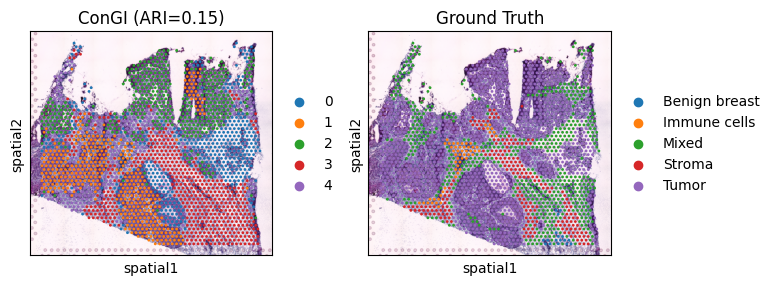

In [13]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.spatial(adata, color=["pred", "label"], title=[f"ConGI (ARI={adjusted_rand_score(pred, label):.2f})", "Ground Truth"])

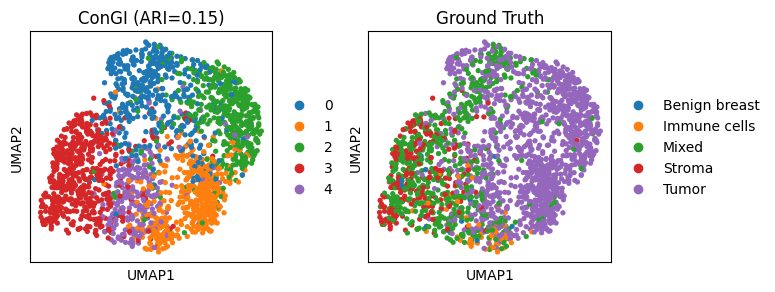

In [14]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.umap(adata, color=["pred", "label"], title=[f"ConGI (ARI={adjusted_rand_score(pred, label):.2f})", "Ground Truth"])

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [16]:
my_labels=adata.obs["label"]
my_data=adata.obsm["ConGI"]

X_train, X_test, y_train, y_test = train_test_split(my_data, my_labels, test_size=0.3, random_state=42)

# Initialiser le modèle Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraîner le modèle
rf.fit(X_train, y_train)

# Faire des prédictions
y_pred = rf.predict(X_test)

# Calculer les performances
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.7463651050080775
Classification Report:
               precision    recall  f1-score   support

Benign breast       0.00      0.00      0.00         5
 Immune cells       0.50      0.12      0.20        16
        Mixed       0.60      0.68      0.63       176
       Stroma       0.58      0.22      0.32        64
        Tumor       0.83      0.91      0.87       358

     accuracy                           0.75       619
    macro avg       0.50      0.39      0.40       619
 weighted avg       0.73      0.75      0.72       619

